In [187]:
import os
import sys
import re
import time
import random
import warnings
import collections
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor
import seaborn as sns

sys.path.append('../../src')
import cb_utils
import ds_matching

sns.set(style="darkgrid")
pd.options.display.max_columns = 500

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### ITC DS Patient Hours Recomendation Model

#### Plan is to train boosted tree model with both sfere features
- Random 10% test set
- Train quartile models
    1. with current hrs
    2. without current hrs

In [189]:
df = pd.read_csv('../data/20231023_sfere_feats.csv', low_memory=False)
print(f'{df.shape[0]} samples')
df = df.loc[df.group_id_ft >= 0]
df.head(20)

7900 samples


,sfere_id,patient_id,sfere_type_ft,payer_id_ft,group_id_ft,age_ft,transfer_bed_to_chair_ft,mobility_ft,dressing_ft,bathing_ft,eating_ft,grooming_ft,toileting_ft,turn_change_position_ft,has_incontinence_ft,incontinence_type_ft,incontinence_frequency_ft,bathing_support_days_natural_ft,dressing_support_days_natural_ft,eating_support_days_natural_ft,grooming_support_days_natural_ft,toileting_support_days_natural_ft,mobility_support_days_natural_ft,transfer_bed_to_chair_support_days_natural_ft,turn_change_position_support_days_natural_ft,bathing_transfers_support_days_natural_ft,dressing_lower_support_days_natural_ft,hair_support_days_natural_ft,mobility_outside_support_days_natural_ft,calling_friends_and_family_ft,articulating_needs_ft,meal_prep_ft,shopping_ft,medication_management_ft,finances_ft,housework_ft,transportation_ft,daily_routine_decisions_ft,comprehension_ft,member_opinion_ft,cleaning_ft,laundry_ft,change_bed_ft,clean_kitchen_ft,clean_home_ft,medical_appointments_ft,work_school_socialize_ft,driving_ft,calling_friends_and_family_support_days_natural_ft,finances_support_days_natural_ft,laundry_support_days_natural_ft,housework_support_days_natural_ft,meal_prep_support_days_natural_ft,medication_management_support_days_natural_ft,shopping_support_days_natural_ft,alert_oriented_self_ft,alert_oriented_place_ft,alert_oriented_day_time_ft,has_alz_or_dem_ft,has_acquired_cognitive_deficit_ft,has_developmental_delay_ft,has_idd_ft,has_no_cog_deficit_ft,has_traumatic_brain_injury_ft,on_ventilator_ft,using_oxygen_ft,has_paralysis_ft,has_amputations_ft,receive_wound_care_ft,has_ostomy_ft,receiving_enteral_feedings_ft,using_specialized_bed_ft,using_mobility_device_ft,has_dme_ft,reporting_current_hrs_ft,reporting_rec_hrs_tg
0,8590,2113,1,4,2,33,3,3,3,3,3,3.0,3,NaN,1,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0,1,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0,0.0,1.0,1.0,1.0,1.0,0.0,14.0,14.0
1,55517,2113,1,4,2,33,3,3,3,3,3,3.0,3,NaN,1,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,1,0,0,0,0,0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0,NaN,1.0,1.0,1.0,1.0,1.0,14.0,14.0
2,6376,2115,1,4,2,69,3,0,3,3,3,3.0,3,NaN,1,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0,1.0,0.0,0.0,1.0,1.0,1.0,20.0,20.0
3,6380,2115,1,4,2,69,3,0,3,3,3,3.0,3,NaN,1,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0,1.0,0.0,0.0,1.0,1.0,1.0,NaN,20.0
4,76130,2115,2,4,2,69,3,0,3,3,3,3.0,3,NaN,1,2.0,2.0,2.0,2.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,3,3,3,3,3,3,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,7.0,7.0,2.0,7.0,7.0,7.0,1.0,1.0,1.0,NaN,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,0,1.0,NaN,NaN,NaN,NaN,NaN,20.0,20.0
5,30255,2116,1,4,2,68,0,0,2,2,0,2.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0,0,2,0,2,0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0,0.0,0.0,0.0,0.0,1.0,0.0,13.0,13.0
6,90034,2116,2,4,2,68,0,0,1,2,0,0.0,0,NaN,1,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,2,2,1,0,3,2,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,7.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,6.0
7,10435,2122,1,4,2,63,0,0,2,2,0,0.0,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,1,2,1,1,2,2,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0
8,25601,2122,1,4,2,63,2,0,2,1,0,2.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,N

In [190]:
# filter out 0 recs
# df = df.loc[df.reporting_rec_hrs_tg > 0]
# print(f'{df.shape[0]} samples above 0')

In [191]:
all_features = [c for c in df.columns if '_ft' in c] + ['sfere_type']
all_features

['sfere_type_ft',
 'payer_id_ft',
 'group_id_ft',
 'age_ft',
 'transfer_bed_to_chair_ft',
 'mobility_ft',
 'dressing_ft',
 'bathing_ft',
 'eating_ft',
 'grooming_ft',
 'toileting_ft',
 'turn_change_position_ft',
 'has_incontinence_ft',
 'incontinence_type_ft',
 'incontinence_frequency_ft',
 'bathing_support_days_natural_ft',
 'dressing_support_days_natural_ft',
 'eating_support_days_natural_ft',
 'grooming_support_days_natural_ft',
 'toileting_support_days_natural_ft',
 'mobility_support_days_natural_ft',
 'transfer_bed_to_chair_support_days_natural_ft',
 'turn_change_position_support_days_natural_ft',
 'bathing_transfers_support_days_natural_ft',
 'dressing_lower_support_days_natural_ft',
 'hair_support_days_natural_ft',
 'mobility_outside_support_days_natural_ft',
 'calling_friends_and_family_ft',
 'articulating_needs_ft',
 'meal_prep_ft',
 'shopping_ft',
 'medication_management_ft',
 'finances_ft',
 'housework_ft',
 'transportation_ft',
 'daily_routine_decisions_ft',
 'comprehension

In [192]:
# sum adls iadls
iadls = [
 'transfer_bed_to_chair_ft',
 'mobility_ft',
 'dressing_ft',
 'bathing_ft',
 'eating_ft',
 'grooming_ft',
 'toileting_ft',
 'turn_change_position_ft',
 'has_incontinence_ft',
 'incontinence_type_ft',
 'incontinence_frequency_ft',
 'calling_friends_and_family_ft',
 'articulating_needs_ft',
 'meal_prep_ft',
 'shopping_ft',
 'medication_management_ft',
 'finances_ft',
 'housework_ft',
 'transportation_ft',
 'daily_routine_decisions_ft',
 'comprehension_ft',
 'member_opinion_ft',
 'cleaning_ft',
 'laundry_ft',
 'change_bed_ft',
 'clean_kitchen_ft',
 'clean_home_ft',
 'medical_appointments_ft',
 'work_school_socialize_ft',
 'driving_ft'
]

supports = [
 'bathing_support_days_natural_ft',
 'dressing_support_days_natural_ft',
 'eating_support_days_natural_ft',
 'grooming_support_days_natural_ft',
 'toileting_support_days_natural_ft',
 'mobility_support_days_natural_ft',
 'transfer_bed_to_chair_support_days_natural_ft',
 'turn_change_position_support_days_natural_ft',
 'bathing_transfers_support_days_natural_ft',
 'dressing_lower_support_days_natural_ft',
 'hair_support_days_natural_ft',
 'mobility_outside_support_days_natural_ft',
 'calling_friends_and_family_support_days_natural_ft',
 'finances_support_days_natural_ft',
 'laundry_support_days_natural_ft',
 'housework_support_days_natural_ft',
 'meal_prep_support_days_natural_ft',
 'medication_management_support_days_natural_ft',
 'shopping_support_days_natural_ft'
]
df = df.assign(total_impairment=df[iadls].sum(axis=1))
df = df.assign(total_supports=df[supports].max(axis=1))
df = df.assign(mean_supports=df[supports].mean(axis=1))
df = df.assign(impairment_rank= df['total_impairment'].rank(pct=True),
               cur_hrs_rank=df.reporting_current_hrs_ft.rank(pct=True),
               rec_hrs_rank=df.reporting_rec_hrs_tg.rank(pct=True)
              )

In [193]:
df.total_supports.value_counts()

7.0    1893
1.0     128
2.0     120
5.0      35
3.0      32
4.0      18
0.0       4
6.0       3
Name: total_supports, dtype: int64

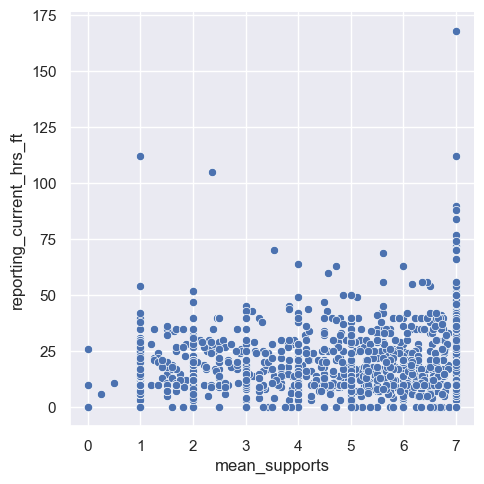

In [194]:
sns.relplot(data=df, x='mean_supports', y='reporting_current_hrs_ft')

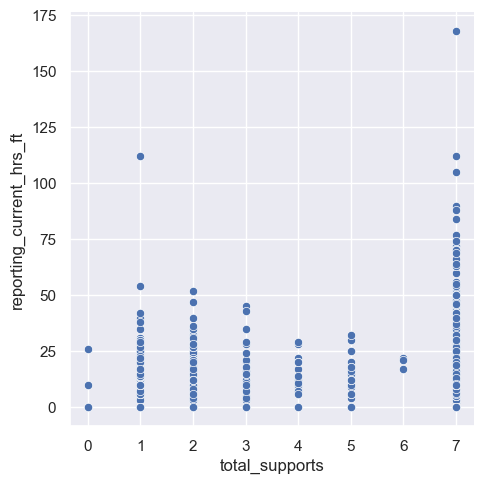

In [195]:
sns.relplot(data=df, x='total_supports', y='reporting_current_hrs_ft')

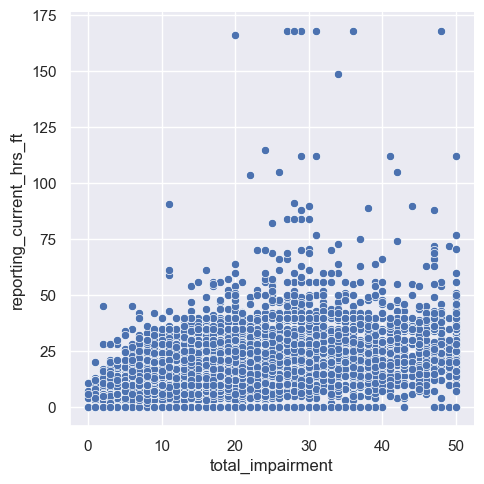

In [196]:
sns.relplot(data=df, x='total_impairment', y='reporting_current_hrs_ft')

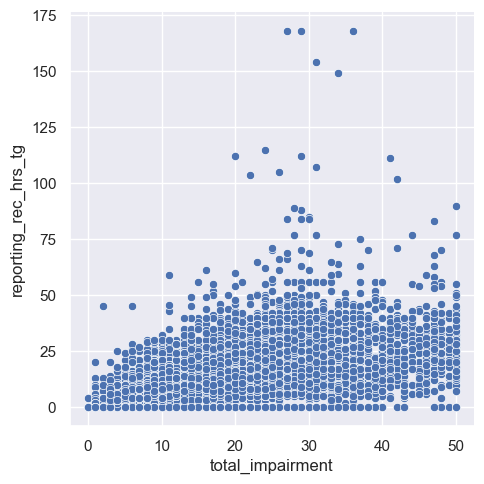

In [197]:
sns.relplot(data=df, x='total_impairment', y='reporting_rec_hrs_tg')

### Features

In [198]:
categorical_features = [
 'transfer_bed_to_chair_ft',
 'mobility_ft',
 'dressing_ft',
 'bathing_ft',
 'eating_ft',
 'grooming_ft',
 'toileting_ft',
 'turn_change_position_ft',
 'has_incontinence_ft',
 'incontinence_type_ft',
 'incontinence_frequency_ft',
 'calling_friends_and_family_ft',
 'articulating_needs_ft',
 'meal_prep_ft',
 'shopping_ft',
 'medication_management_ft',
 'finances_ft',
 'housework_ft',
 'transportation_ft',
 'daily_routine_decisions_ft',
 'comprehension_ft',
 'member_opinion_ft',
 'cleaning_ft',
 'laundry_ft',
 'change_bed_ft',
 'clean_kitchen_ft',
 'clean_home_ft',
 'medical_appointments_ft',
 'work_school_socialize_ft',
 'driving_ft',
 'on_ventilator_ft',
 'using_oxygen_ft',
 'has_paralysis_ft',
 'has_amputations_ft',
 'receive_wound_care_ft',
 'has_ostomy_ft',
 'receiving_enteral_feedings_ft',
 'using_specialized_bed_ft',
 'using_mobility_device_ft',
 'has_dme_ft',
 'sfere_type_ft',
 'payer_id_ft',
 'group_id_ft']

cont_features = [
 # 'reporting_current_hrs_ft',
 'mean_supports',
 # 'total_supports',
 'age_ft',
]
 

features = categorical_features + cont_features
target = 'reporting_rec_hrs_tg'
categorical_feature_indexes = [i for i in range(len(categorical_features))]

In [199]:
# make sure data always exists
missing_cat = df[categorical_features].count() / df.shape[0]
# features present in < 50% samples
low_freq_feats = [x for x in missing_cat.items() if x[1] <= .2]
low_freq_feats 

[('turn_change_position_ft', 0.0),
 ('cleaning_ft', 0.0),
 ('change_bed_ft', 0.0),
 ('clean_kitchen_ft', 0.0),
 ('clean_home_ft', 0.0),
 ('medical_appointments_ft', 0.0),
 ('work_school_socialize_ft', 0.0)]

In [200]:
# Likely want to drop low frequency features in categorical vars
lf_feats = [lff[0] for lff in low_freq_feats]
features = [f for f in features if f not in lf_feats]
features

['transfer_bed_to_chair_ft',
 'mobility_ft',
 'dressing_ft',
 'bathing_ft',
 'eating_ft',
 'grooming_ft',
 'toileting_ft',
 'has_incontinence_ft',
 'incontinence_type_ft',
 'incontinence_frequency_ft',
 'calling_friends_and_family_ft',
 'articulating_needs_ft',
 'meal_prep_ft',
 'shopping_ft',
 'medication_management_ft',
 'finances_ft',
 'housework_ft',
 'transportation_ft',
 'daily_routine_decisions_ft',
 'comprehension_ft',
 'member_opinion_ft',
 'laundry_ft',
 'driving_ft',
 'on_ventilator_ft',
 'using_oxygen_ft',
 'has_paralysis_ft',
 'has_amputations_ft',
 'receive_wound_care_ft',
 'has_ostomy_ft',
 'receiving_enteral_feedings_ft',
 'using_specialized_bed_ft',
 'using_mobility_device_ft',
 'has_dme_ft',
 'sfere_type_ft',
 'payer_id_ft',
 'group_id_ft',
 'mean_supports',
 'age_ft']

In [201]:
new_categorical_feature_indexes = categorical_feature_indexes[:-len(low_freq_feats)]
len(features) - len(new_categorical_feature_indexes) == len(cont_features)

True

### Train Test Split

In [202]:
test_pct = 0.1

patient_ids = df.patient_id.unique().tolist()
test_df_patient_ids = random.sample(patient_ids, int(df.shape[0]*test_pct))

test_df = df.loc[df.patient_id.isin(test_df_patient_ids)]
training_df = df.loc[~df.patient_id.isin(test_df_patient_ids)]

print(f'{test_df.shape[0]} test samples, for {len(test_df_patient_ids)} unique patients')
print(f'{training_df.shape[0]} training samples, for {training_df.patient_id.unique().shape[0]} unique patients')

1034 test samples, for 788 unique patients
6855 training samples, for 5191 unique patients


### validate data splits

In [203]:
test_df[target].describe()

count    1034.000000
mean       15.652321
std        11.613481
min         0.000000
25%         7.000000
50%        14.000000
75%        21.000000
max        69.000000
Name: reporting_rec_hrs_tg, dtype: float64

In [204]:
training_df[target].describe()

count    6855.000000
mean       15.713895
std        12.976786
min         0.000000
25%         7.000000
50%        13.000000
75%        21.000000
max       168.000000
Name: reporting_rec_hrs_tg, dtype: float64

<AxesSubplot:>

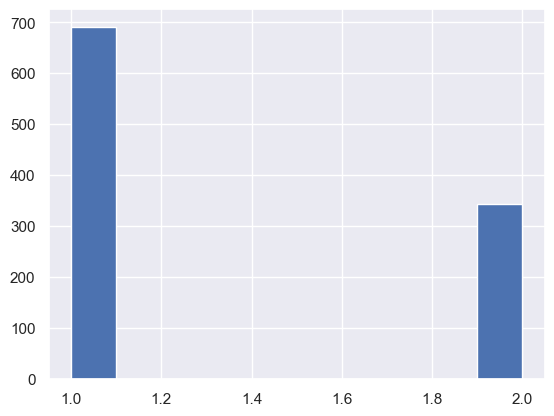

In [206]:
test_df['sfere_type_ft'].hist()

<AxesSubplot:>

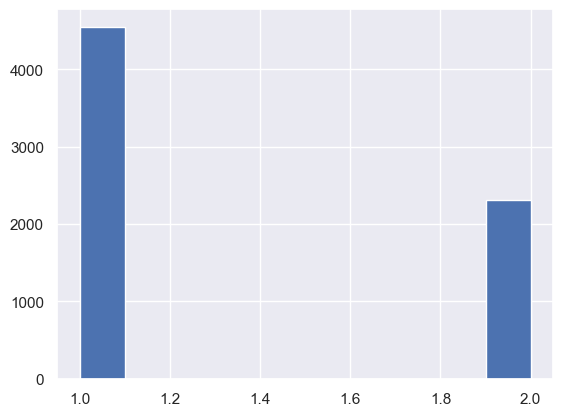

In [208]:
# training_df[target].hist()
training_df['sfere_type_ft'].hist()

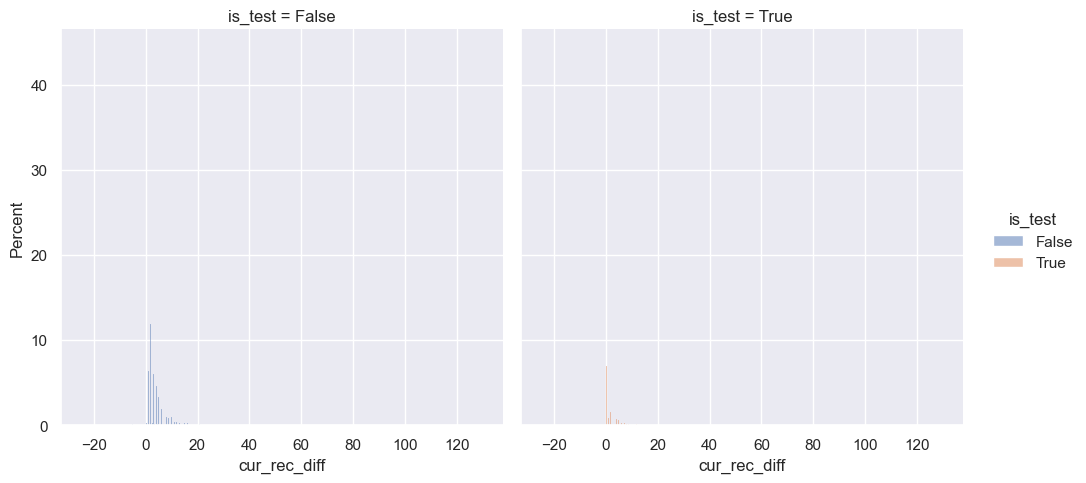

In [209]:
plt_df = df.assign(is_test=df.patient_id.isin(test_df_patient_ids), cur_rec_diff=df.reporting_current_hrs_ft - df.reporting_rec_hrs_tg)
# plt_df.cur_rec_diff.hist(bins=100)
sns.displot(plt_df, x='cur_rec_diff', col='is_test', hue='is_test', stat='percent')

### Training

In [210]:
x_train = training_df[features]
y_train = training_df[target]
x_test = test_df[features]
y_test = test_df[target]

aa_est = HistGradientBoostingRegressor(categorical_features=new_categorical_feature_indexes,
                                       max_iter=1000).fit(x_train, y_train)

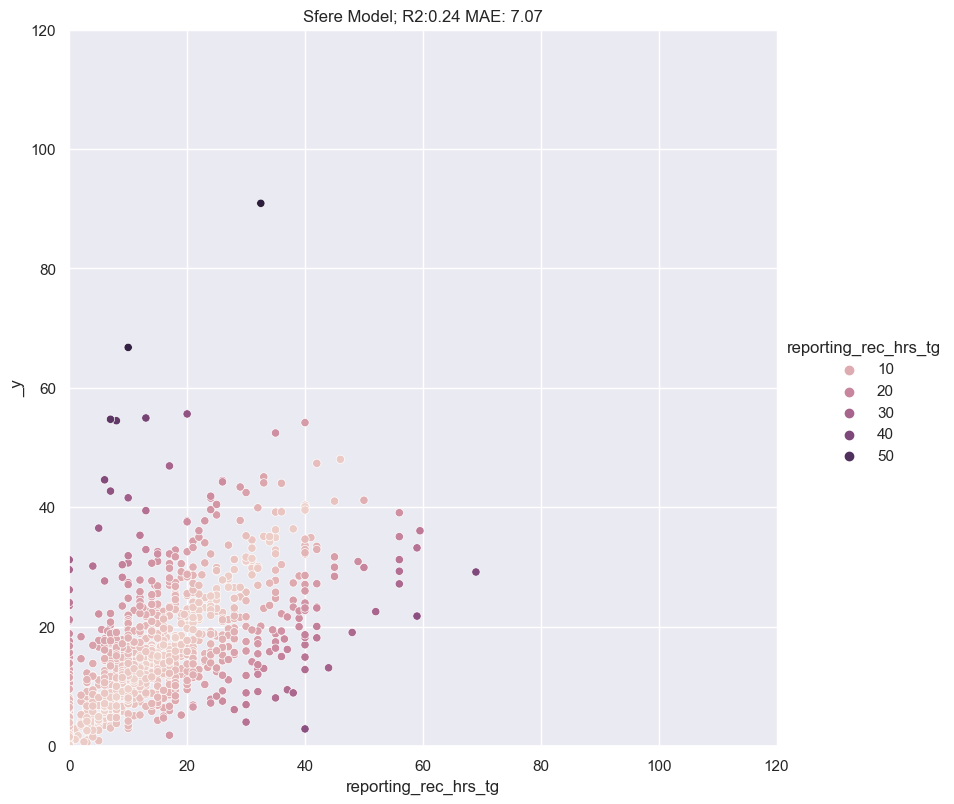

In [211]:
aa_preds = aa_est.predict(x_test)

# preds vs rec
ax = sns.relplot(x=y_test, y=aa_preds, height=8, hue=np.abs(y_test - aa_preds))
ax.set(ylim=(0, 120))
ax.set(xlim=(0, 120))
ax.set(title=f'Sfere Model; R2:{aa_est.score(x_test, y_test):.02f} MAE: {np.mean(np.abs(y_test - aa_preds)):.02f}');
plt.show()


In [212]:
print(f'Feature importances')
r = permutation_importance(aa_est, x_train, y_train,
                           n_jobs=-1,
                           n_repeats=50,
                           random_state=0)

best_features = []
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        best_features.append(features[i])
        print(f"{features[i]:<8} "
              f"{r.importances_mean[i]:.3f} "
              f" +/- {r.importances_std[i]:.3f}")

Feature importances
age_ft   0.344  +/- 0.007
transfer_bed_to_chair_ft 0.102  +/- 0.003
eating_ft 0.092  +/- 0.003
toileting_ft 0.084  +/- 0.002
mean_supports 0.081  +/- 0.002
meal_prep_ft 0.081  +/- 0.003
grooming_ft 0.074  +/- 0.002
housework_ft 0.066  +/- 0.002
dressing_ft 0.061  +/- 0.001
mobility_ft 0.058  +/- 0.001
bathing_ft 0.055  +/- 0.001
receive_wound_care_ft 0.053  +/- 0.002
medication_management_ft 0.046  +/- 0.002
incontinence_frequency_ft 0.044  +/- 0.001
incontinence_type_ft 0.039  +/- 0.002
shopping_ft 0.037  +/- 0.002
finances_ft 0.033  +/- 0.001
calling_friends_and_family_ft 0.033  +/- 0.001
transportation_ft 0.029  +/- 0.001
using_oxygen_ft 0.028  +/- 0.002
has_paralysis_ft 0.027  +/- 0.002
using_specialized_bed_ft 0.026  +/- 0.001
on_ventilator_ft 0.025  +/- 0.001
member_opinion_ft 0.025  +/- 0.001
has_dme_ft 0.020  +/- 0.001
using_mobility_device_ft 0.019  +/- 0.001
receiving_enteral_feedings_ft 0.019  +/- 0.001
articulating_needs_ft 0.017  +/- 0.001
daily_routine

### Add in current hrs

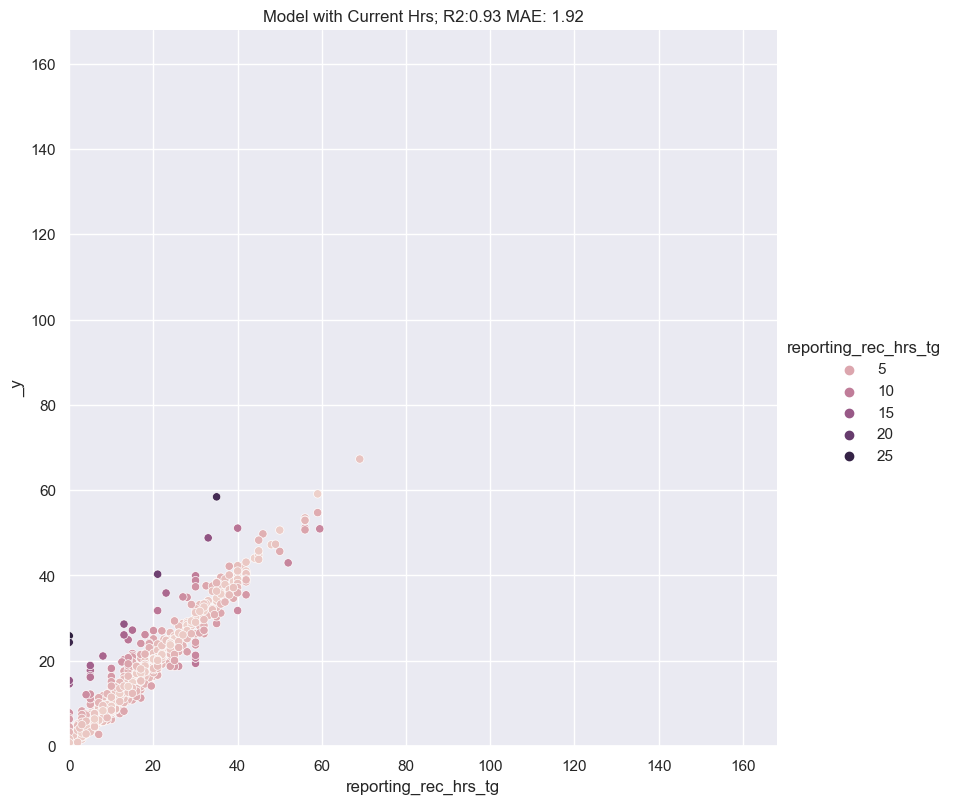

Feature importance with current hrs
reporting_current_hrs_ft 1.501  +/- 0.022
age_ft   0.017  +/- 0.000
receiving_enteral_feedings_ft 0.011  +/- 0.001
toileting_ft 0.010  +/- 0.000
bathing_ft 0.010  +/- 0.000
mean_supports 0.008  +/- 0.000
eating_ft 0.006  +/- 0.000
housework_ft 0.006  +/- 0.000
dressing_ft 0.006  +/- 0.000
grooming_ft 0.005  +/- 0.000
meal_prep_ft 0.005  +/- 0.000
medication_management_ft 0.004  +/- 0.000
mobility_ft 0.004  +/- 0.000
shopping_ft 0.003  +/- 0.000
incontinence_frequency_ft 0.003  +/- 0.000
using_specialized_bed_ft 0.003  +/- 0.000
receive_wound_care_ft 0.003  +/- 0.000
transfer_bed_to_chair_ft 0.003  +/- 0.000
member_opinion_ft 0.002  +/- 0.000
transportation_ft 0.002  +/- 0.000
incontinence_type_ft 0.002  +/- 0.000
calling_friends_and_family_ft 0.002  +/- 0.000
finances_ft 0.002  +/- 0.000
using_mobility_device_ft 0.001  +/- 0.000
has_dme_ft 0.001  +/- 0.000
articulating_needs_ft 0.001  +/- 0.000
has_paralysis_ft 0.001  +/- 0.000
daily_routine_decision

In [213]:
# can add to end b/c continuous features are always last after cat feats
features_w_cur_hrs = features + ['reporting_current_hrs_ft']

x_train = training_df[features_w_cur_hrs]
y_train = training_df[target]
x_val = test_df[features_w_cur_hrs]
y_val = test_df[target]

aa_est_ch = HistGradientBoostingRegressor(categorical_features=new_categorical_feature_indexes,
                                       max_iter=1000).fit(x_train, y_train)

aa_preds_ch = aa_est_ch.predict(x_val)

# preds vs rec
ax = sns.relplot(x=y_val, y=aa_preds_ch, height=8, hue=np.abs(y_val - aa_preds_ch))
ax.set(ylim=(0, 168))
ax.set(xlim=(0, 168))
ax.set(title=f'Model with Current Hrs; R2:{aa_est_ch.score(x_val, y_val):.02f} MAE: {np.mean(np.abs(y_val - aa_preds_ch)):.02f}');
plt.show()

print(f'Feature importance with current hrs')
r = permutation_importance(aa_est_ch, x_train, y_train,
                           n_jobs=-1,
                           n_repeats=50,
                           random_state=0)

best_features_ch = []
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        best_features_ch.append(features_w_cur_hrs[i])
        print(f"{features_w_cur_hrs[i]:<8} "
              f"{r.importances_mean[i]:.3f} "
              f" +/- {r.importances_std[i]:.3f}")
#

### Save training set for sagemaker

In [214]:
target

'reporting_rec_hrs_tg'

In [216]:
target_plus_features = [
 'reporting_rec_hrs_tg',
 'transfer_bed_to_chair_ft',
 'mobility_ft',
 'dressing_ft',
 'bathing_ft',
 'eating_ft',
 'grooming_ft',
 'toileting_ft',
 'has_incontinence_ft',
 'incontinence_type_ft',
 'incontinence_frequency_ft',
 'calling_friends_and_family_ft',
 'articulating_needs_ft',
 'meal_prep_ft',
 'shopping_ft',
 'medication_management_ft',
 'finances_ft',
 'housework_ft',
 'transportation_ft',
 'daily_routine_decisions_ft',
 'comprehension_ft',
 'member_opinion_ft',
 'laundry_ft',
 'driving_ft',
 'on_ventilator_ft',
 'using_oxygen_ft',
 'has_paralysis_ft',
 'has_amputations_ft',
 'receive_wound_care_ft',
 'has_ostomy_ft',
 'receiving_enteral_feedings_ft',
 'using_specialized_bed_ft',
 'using_mobility_device_ft',
 'has_dme_ft',
 'sfere_type_ft',
 'payer_id_ft',
 'group_id_ft',
 'mean_supports',
 'age_ft'
]


In [217]:
df[target_plus_features].head()

,reporting_rec_hrs_tg,transfer_bed_to_chair_ft,mobility_ft,dressing_ft,bathing_ft,eating_ft,grooming_ft,toileting_ft,has_incontinence_ft,incontinence_type_ft,incontinence_frequency_ft,calling_friends_and_family_ft,articulating_needs_ft,meal_prep_ft,shopping_ft,medication_management_ft,finances_ft,housework_ft,transportation_ft,daily_routine_decisions_ft,comprehension_ft,member_opinion_ft,laundry_ft,driving_ft,on_ventilator_ft,using_oxygen_ft,has_paralysis_ft,has_amputations_ft,receive_wound_care_ft,has_ostomy_ft,receiving_enteral_feedings_ft,using_specialized_bed_ft,using_mobility_device_ft,has_dme_ft,sfere_type_ft,payer_id_ft,group_id_ft,mean_supports,age_ft
0,14.0,3,3,3,3,3,3.0,3,1,NaN,2.0,1,1.0,1,1,1,1,1,1,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,0,0.0,1.0,1.0,1.0,1.0,0.0,1,4,2,NaN,33
1,14.0,3,3,3,3,3,3.0,3,1,2.0,2.0,0,0.0,1,0,0,0,0,0,0.0,1.0,1.0,NaN,0.0,0.0,1.0,1.0,0,NaN,1.0,1.0,1.0,1.0,1.0,1,4,2,NaN,33
2,20.0,3,0,3,3,3,3.0,3,1,NaN,2.0,0,0.0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0,1.0,0.0,0.0,1.0,1.0,1.0,1,4,2,NaN,69
3,20.0,3,0,3,3,3,3.0,3,1,NaN,2.0,0,0.0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0,1.0,0.0,0.0,1.0,1.0,1.0,1,4,2,NaN,69
4,20.0,3,0,3,3,3,3.0,3,1,2.0,2.0,3,NaN,3,3,3,3,3,3,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,0,1.0,NaN,NaN,NaN,NaN,NaN,2,4,2,5.75,69


In [219]:
df[target_plus_features].to_csv('../data/202301023_fl_sfere_features_for_sagemaker.csv', index=False, header=False)

### Next steps

in the test set
- the number we would flag as outliers vs number that were actually flagged as outliers (went for review)

In [181]:
pred_std_error = np.std(np.abs(y_test - aa_preds))

In [182]:
pred_std_error_ch = np.std(np.abs(y_val -  aa_preds_ch))

In [29]:
training_data_file = '../data/itc_training_data_20230127.csv'
df[['reporting_rec_hrs_tg'] + features + ['reporting_current_hrs_ft']].to_csv(training_data_file, index=False, header=False)

In [31]:
import boto3
from time import gmtime, strftime

In [32]:
s3 = boto3.client('s3')

bucket = 'cb-analytics-us-east-2-prd'
prefix = 'sagemaker/training_data'
key = f'{prefix}/{strftime("%Y%m%d%H%M%S", gmtime())}_itc_traning_data.csv'

s3.upload_file(training_data_file, bucket, key, ExtraArgs={'ServerSideEncryption': 'AES256'})
key

'sagemaker/training_data/20230127201843_itc_traning_data.csv'

### Sagemaker Training
Broken out into separate notebook that needs to be run on a sagemaker notebook instance in the aws console

In [ ]:
raise "Stop"

In [ ]:
# TODO clean up the following pulled from previous NB

### Patient Similarity model
- Find the k (in this case 10) most similar patients to a single patient within the context of the payer
- Can compare signle patient to mean/median min/max of 10 "neighbors"
- Can also look at the 10 neighbors, see how they are similar

In [34]:
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor
from sklearn.preprocessing import RobustScaler
# X = [[ 1., -2.,  2.],
#      [ -2.,  1.,  3.],
#      [ 4.,  1., -2.]]
# transformer = RobustScaler().fit(X)
# transformer

# transformer.transform(X)

#### These are the dimensions over which we calc similarity
Currently just adls and age

In [35]:
features

['transfer_bed_to_chair_ft',
 'transfer_chair_to_standing_ft',
 'mobility_ft',
 'dressing_ft',
 'bathing_ft',
 'eating_ft',
 'grooming_ft',
 'toileting_ft',
 'has_incontinence_ft',
 'incontinence_type_ft',
 'incontinence_frequency_ft',
 'calling_friends_and_family_ft',
 'articulating_needs_ft',
 'meal_prep_ft',
 'shopping_ft',
 'medication_management_ft',
 'finances_ft',
 'housework_ft',
 'transportation_ft',
 'daily_routine_decisions_ft',
 'comprehension_ft',
 'member_opinion_ft',
 'driving_ft',
 'alert_oriented_self_ft',
 'alert_oriented_place_ft',
 'alert_oriented_day_time_ft',
 'has_alzheimers_ft',
 'has_dementia_ft',
 'group_id_ft',
 'age_ft']

In [42]:
df.group_id_ft.value_counts()

7    1709
6     187
4     161
3      84
5      35
2      28
1      28
0      15
8       3
9       1
Name: group_id_ft, dtype: int64

In [41]:
neighbors = {}
k = 100

x_train = df[[f for f in features if f != 'group_id_ft']

pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('scaler', preprocessing.RobustScaler())])
pipe.fit(x_train)
x = pipe.transform(x_train)
nn = NearestNeighbors(n_neighbors=k).fit(x)
distances, nn_idxs = nn.kneighbors()

# get patient_ids
for i, nn_idx in enumerate(nn_idxs): 
    neighbors[df.iloc[i].patient_id] = df.iloc[nn_idx].patient_id.values

In [ ]:
rows = []
for pid in df.patient_id.unique():
    pid_neighbors = df.loc[df.patient_id.isin(neighbors[pid])]
    p = df.loc[df.patient_id == pid]
    
    rows.append([pid, p.reporting_rec_hrs.mean(), pid_neighbors.reporting_rec_hrs.mean(), pid_neighbors.reporting_rec_hrs.median(), pid_neighbors.reporting_rec_hrs.min(), pid_neighbors.reporting_rec_hrs.max()])
nn_df = pd.DataFrame(rows, columns=['patient_id', 'rec_hrs', 'mean_nn', 'median_nn', 'min_nn', 'max_nn']) 
nn_df.head()

In [ ]:
# calc ranges and mean abs error
nn_df = nn_df.assign(exact_in_range=np.where((nn_df.rec_hrs >= nn_df.min_nn) & (nn_df.rec_hrs <= nn_df.max_nn), 1, 0),
                     hrs_range=nn_df.max_nn - nn_df.min_nn,
                     in_range=np.where((nn_df.rec_hrs - nn_df.min_nn > -1) & (nn_df.rec_hrs - nn_df.max_nn < 1), 1, 0))

nn_df = nn_df.assign(mean_err=np.abs(nn_df.mean_nn - nn_df.rec_hrs), median_err=np.abs(nn_df.median_nn - nn_df.rec_hrs))

In [ ]:
nn_df.head()

In [ ]:
print(f'Percent rec hrs in neighbors range: {nn_df.in_range.sum() * 100 / nn_df.shape[0]}')
print(f'Percent rec hrs in exact neighbors range: {nn_df.exact_in_range.sum() * 100 / nn_df.shape[0]}')

In [ ]:
nn_df.describe()

### Check random patient's neighbors
In practice could show top 10 most similar patients

In [ ]:
pid = nn_df.patient_id.sample().values[0]
pid_neighbors = df.loc[df.patient_id.isin(neighbors[pid])]
print(f'Patient id {pid}, neighbor mean/range: {pid_neighbors.reporting_rec_hrs.mean()}; {pid_neighbors.reporting_rec_hrs.min()} - {pid_neighbors.reporting_rec_hrs.max()}')
pid_neighbors 